# DelaunayInterfaces Python Examples

This notebook demonstrates the Python bindings for computing interface surfaces from multicolored point clouds.

In [22]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import to_rgb

# Add build directory to path (adjust if needed)
sys.path.insert(0, '../build/python')
import delaunay_interfaces as di

print(f"DelaunayInterfaces version: {di.__version__}")

DelaunayInterfaces version: 0.1.0


## Helper Functions for Visualization

In [23]:
# Color scheme matching Julia's Dark2_4
CONF_COLORS = [
    '#1b9e77',  # teal
    '#d95f02',  # orange
    '#7570b3',  # purple
    '#e7298a',  # pink
]

# Interface color matching Julia's RGBAf(0.27, 0.51, 0.71, 0.7)
INTERFACE_COLOR = (0.27, 0.51, 0.71, 0.7)

def get_color(label):
    """Get color for a given label (1-indexed)."""
    return CONF_COLORS[(label - 1) % len(CONF_COLORS)]


def set_equal_aspect(ax, all_points):
    """Set equal aspect ratio for 3D axes based on all points."""
    if len(all_points) == 0:
        return
    pts = np.array(all_points)
    max_range = np.max(np.ptp(pts, axis=0)) / 2
    mid = np.mean(pts, axis=0)
    # Add small padding
    max_range *= 1.1
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)


def plot_interface_surface(surface, ax, title="", show_wireframe=True, extra_points=None):
    """Plot the interface surface in monocolor with black wireframe.
    
    Matches the style of Julia's right panel visualization.
    """
    vertices = surface.vertices
    
    # Extract triangles
    triangles = []
    for simplex, value in surface.filtration:
        if len(simplex) == 3:
            tri_verts = vertices[simplex]
            triangles.append(tri_verts)
    
    if triangles:
        poly = Poly3DCollection(triangles, alpha=0.7,
                                edgecolor='black' if show_wireframe else 'none',
                                linewidth=0.5 if show_wireframe else 0)
        poly.set_facecolor(INTERFACE_COLOR)
        ax.add_collection3d(poly)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if title:
        ax.set_title(title)
    
    # Equal aspect ratio - include extra points if provided
    all_points = list(vertices)
    if extra_points is not None:
        all_points.extend(extra_points)
    set_equal_aspect(ax, all_points)


def plot_tetrahedron_subdivision(points, colors, surface, title=""):
    """Create a dual-panel figure for tetrahedron visualization.

    Left: Monocolor interface with points and tetrahedron edges
    Right: Monocolor interface with barycenter dots
    """
    fig = plt.figure(figsize=(12, 5))

    # Left: Interface with points and edges
    ax1 = fig.add_subplot(121, projection='3d')
    plot_interface_surface(surface, ax1, title='Tetrahedron and Interface', extra_points=points)

    # Draw points colored by label
    pts = np.array(points)
    point_colors = [get_color(c) for c in colors]
    ax1.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=point_colors, s=100, zorder=5)

    # Draw tetrahedron edges with gradient colors
    n = len(points)
    for i in range(n):
        for j in range(i + 1, n):
            p1, p2 = pts[i], pts[j]
            c1, c2 = to_rgb(get_color(colors[i])), to_rgb(get_color(colors[j]))
            # Draw gradient by interpolating
            num_segments = 10
            for k in range(num_segments):
                t1, t2 = k / num_segments, (k + 1) / num_segments
                seg_p1 = p1 + t1 * (p2 - p1)
                seg_p2 = p1 + t2 * (p2 - p1)
                seg_c = tuple((1 - (t1 + t2) / 2) * np.array(c1) + (t1 + t2) / 2 * np.array(c2))
                ax1.plot([seg_p1[0], seg_p2[0]], [seg_p1[1], seg_p2[1]], [seg_p1[2], seg_p2[2]],
                         color=seg_c, linewidth=2)

    # Right: Monocolor interface with barycenter dots
    ax2 = fig.add_subplot(122, projection='3d')
    plot_interface_surface(surface, ax2, title='Interface and Barycenters', extra_points=points)

    # Draw red barycenter dots
    verts = np.array(surface.vertices)
    ax2.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c='red', s=20, zorder=5)

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    return fig


def plot_pointcloud_subdivision(points, colors, surface, title=""):
    """Create a dual-panel figure for point cloud visualization.

    Left: Monocolor interface with points
    Right: Monocolor interface with barycenter dots
    """
    fig = plt.figure(figsize=(12, 5))

    # Left: Interface with points
    ax1 = fig.add_subplot(121, projection='3d')
    plot_interface_surface(surface, ax1, title='Pointcloud and Interface', extra_points=points)

    # Draw points colored by label
    pts = np.array(points)
    point_colors = [get_color(c) for c in colors]
    ax1.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=point_colors, s=30, zorder=5)

    # Right: Monocolor interface with barycenter dots
    ax2 = fig.add_subplot(122, projection='3d')
    plot_interface_surface(surface, ax2, title='Interface and Barycenters', extra_points=points)

    # Draw red barycenter dots
    verts = np.array(surface.vertices)
    ax2.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c='red', s=4, zorder=5)

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    return fig


def plot_interface_and_pointcloud(surface, points, colors, radii, title=""):
    """Create a dual-panel figure for protein/large point cloud visualization.

    Left: Point cloud as spheres
    Right: Monocolor interface surface
    """
    fig = plt.figure(figsize=(12, 5))

    # Left: Point cloud
    ax1 = fig.add_subplot(121, projection='3d')
    pts = np.array(points)
    point_colors = [get_color(c) for c in colors]
    # Scale marker size by radius (approximate)
    sizes = np.array(radii) * 10
    ax1.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=point_colors, s=sizes, alpha=0.6)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Atom Centers')
    set_equal_aspect(ax1, points)

    # Right: Monocolor interface surface
    ax2 = fig.add_subplot(122, projection='3d')
    plot_interface_surface(surface, ax2, title='Interface', show_wireframe=False)

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    return fig

## 1. Random Point Cloud Example

Random point cloud: 20 points, 3 colors
Interface: 224 vertices, 432 triangles


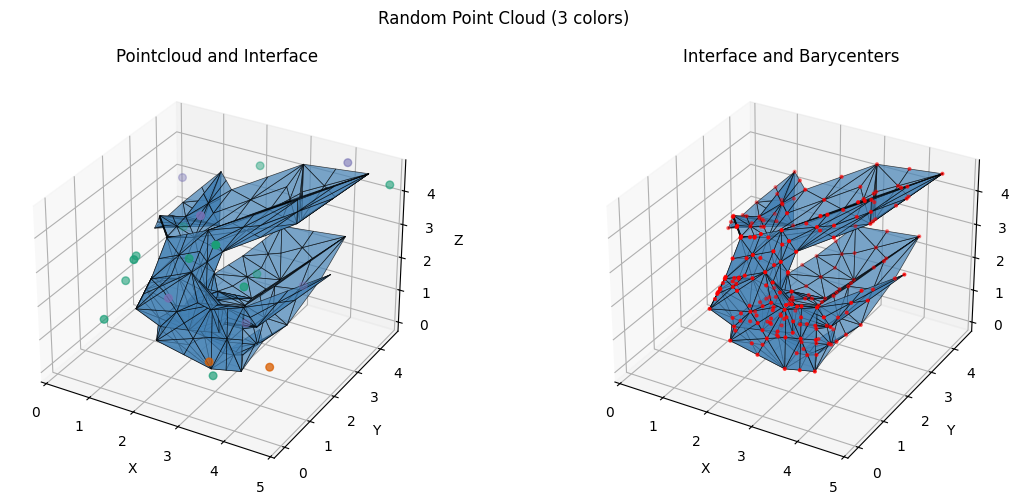

In [24]:
# Generate a random point cloud
np.random.seed(42)
n_points = 20
n_colors = 3

rand_points = (np.random.rand(n_points, 3) * 5).tolist()
rand_colors = np.random.randint(1, n_colors + 1, n_points).tolist()

# Compute unweighted Delaunay interface
gen = di.InterfaceGenerator()
rand_surface = gen.compute_interface_surface(rand_points, rand_colors, [], False, False)

num_triangles = sum(1 for s, v in rand_surface.filtration if len(s) == 3)
print(f"Random point cloud: {n_points} points, {n_colors} colors")
print(f"Interface: {len(rand_surface.vertices)} vertices, {num_triangles} triangles")

fig = plot_pointcloud_subdivision(rand_points, rand_colors, rand_surface, f"Random Point Cloud ({n_colors} colors)")
plt.show()

## 2. Tetrahedron Examples

These examples use the same configurations from the C++ test suite.

In [25]:
# Rotation helper - rotate points around axis by angle (Rodrigues' formula)
def rotate_points(points, axis, angle):
    axis = np.array(axis)
    axis = axis / np.linalg.norm(axis)
    K = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0, -axis[0]],
                  [-axis[1], axis[0], 0]])
    R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * K @ K
    return [list(R @ np.array(p)) for p in points]

# 1-1-1-1 partition: Unit tetrahedron with 4 distinct colors (slightly rotated)
UNIT_TETRAHEDRON_BASE = [
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0]
]
UNIT_TETRAHEDRON = rotate_points(UNIT_TETRAHEDRON_BASE, [1.0, 0.5, 0.7], np.pi/6)

EXAMPLE_1111 = {
    'name': '1-1-1-1 Partition',
    'points': UNIT_TETRAHEDRON,
    'colors': [1, 2, 3, 4],
    'expected_vertices': 11,
    'expected_triangles': 12
}

# Shared points for 2-2 and 2-1-1 examples
SHARED_TETRAHEDRON = [[-1.0, -1.0, 0.0], [1.0, -1.0, 0.0], [0.0, 1.0, -1.0], [0.0, 1.0, 1.0]]

# 2-2 partition: Two points at y=-1 (color 1), two at y=1 (color 2)
EXAMPLE_22 = {
    'name': '2-2 Partition',
    'points': SHARED_TETRAHEDRON,
    'colors': [1, 1, 2, 2],
    'expected_vertices': 9,
    'expected_triangles': 8
}

# 2-1-1 partition: Same points, different coloring
EXAMPLE_211 = {
    'name': '2-1-1 Partition',
    'points': SHARED_TETRAHEDRON,
    'colors': [1, 1, 2, 3],
    'expected_vertices': 10,
    'expected_triangles': 10
}

# 3-1 partition: Equilateral triangle at y=-1, apex at y=1
r = 1.0
EXAMPLE_31 = {
    'name': '3-1 Partition',
    'points': [
        [r, -1.0, 0.0],
        [-r/2, -1.0, r*np.sqrt(3)/2],
        [-r/2, -1.0, -r*np.sqrt(3)/2],
        [0.0, 1.0, 0.0]
    ],
    'colors': [1, 1, 1, 2],
    'expected_vertices': 7,
    'expected_triangles': 6
}

# Verify all tetrahedron examples
gen = di.InterfaceGenerator()
for example in [EXAMPLE_1111, EXAMPLE_22, EXAMPLE_211, EXAMPLE_31]:
    surface = gen.compute_interface_surface(example['points'], example['colors'], [], False, False)
    num_verts = len(surface.vertices)
    num_tris = sum(1 for s, v in surface.filtration if len(s) == 3)
    
    print(f"\n{example['name']}:")
    print(f"  Colors: {example['colors']}")
    print(f"  Vertices: {num_verts} (expected {example['expected_vertices']})")
    print(f"  Triangles: {num_tris} (expected {example['expected_triangles']})")


1-1-1-1 Partition:
  Colors: [1, 2, 3, 4]
  Vertices: 11 (expected 11)
  Triangles: 12 (expected 12)

2-2 Partition:
  Colors: [1, 1, 2, 2]
  Vertices: 9 (expected 9)
  Triangles: 8 (expected 8)

2-1-1 Partition:
  Colors: [1, 1, 2, 3]
  Vertices: 10 (expected 10)
  Triangles: 10 (expected 10)

3-1 Partition:
  Colors: [1, 1, 1, 2]
  Vertices: 7 (expected 7)
  Triangles: 6 (expected 6)


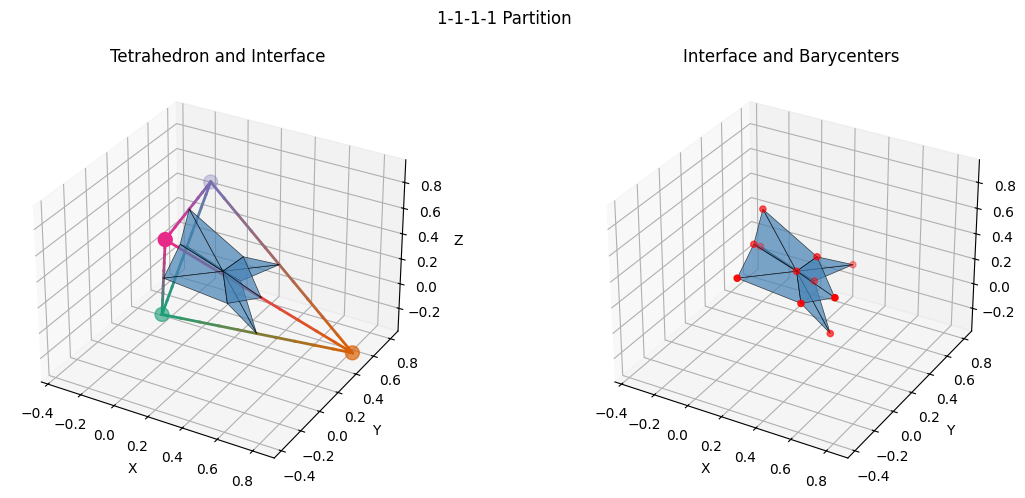

In [26]:
# Visualize 1-1-1-1 partition
surface = gen.compute_interface_surface(EXAMPLE_1111['points'], EXAMPLE_1111['colors'], [], False, False)
fig = plot_tetrahedron_subdivision(EXAMPLE_1111['points'], EXAMPLE_1111['colors'], surface,
                                    title=EXAMPLE_1111['name'])
plt.show()

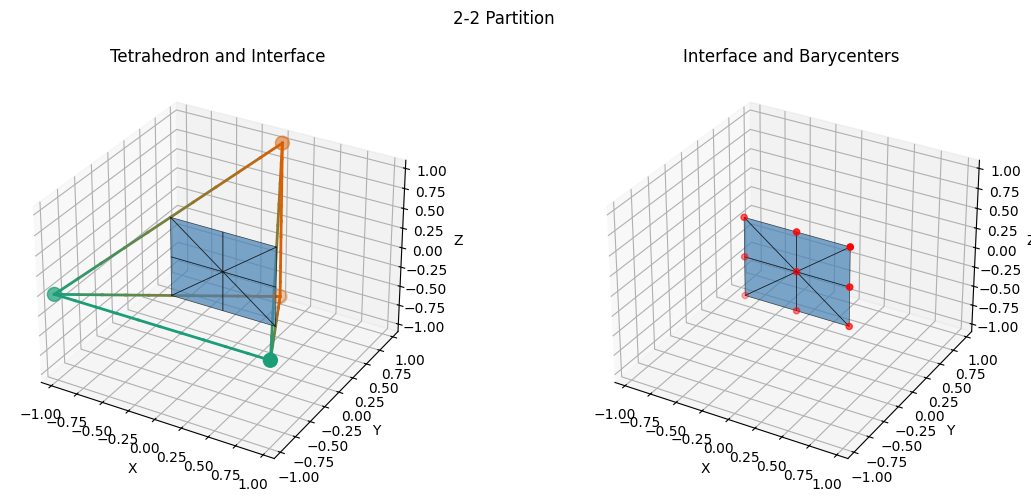

In [27]:
# Visualize 2-2 partition
surface = gen.compute_interface_surface(EXAMPLE_22['points'], EXAMPLE_22['colors'], [], False, False)
fig = plot_tetrahedron_subdivision(EXAMPLE_22['points'], EXAMPLE_22['colors'], surface,
                                    title=EXAMPLE_22['name'])
plt.show()

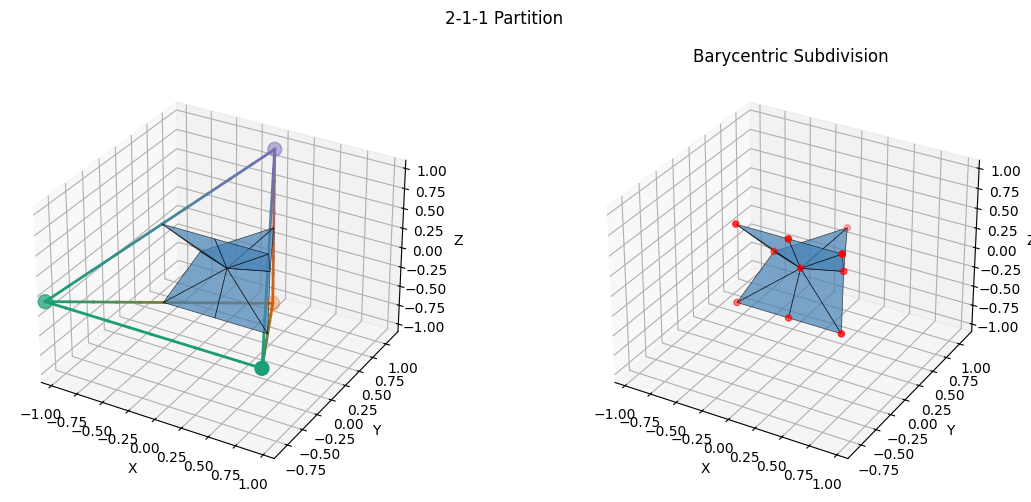

In [7]:
# Visualize 2-1-1 partition (same points as 2-2, different colors)
surface = gen.compute_interface_surface(EXAMPLE_211['points'], EXAMPLE_211['colors'], [], False, False)
fig = plot_tetrahedron_subdivision(EXAMPLE_211['points'], EXAMPLE_211['colors'], surface,
                                    title=EXAMPLE_211['name'])
plt.show()

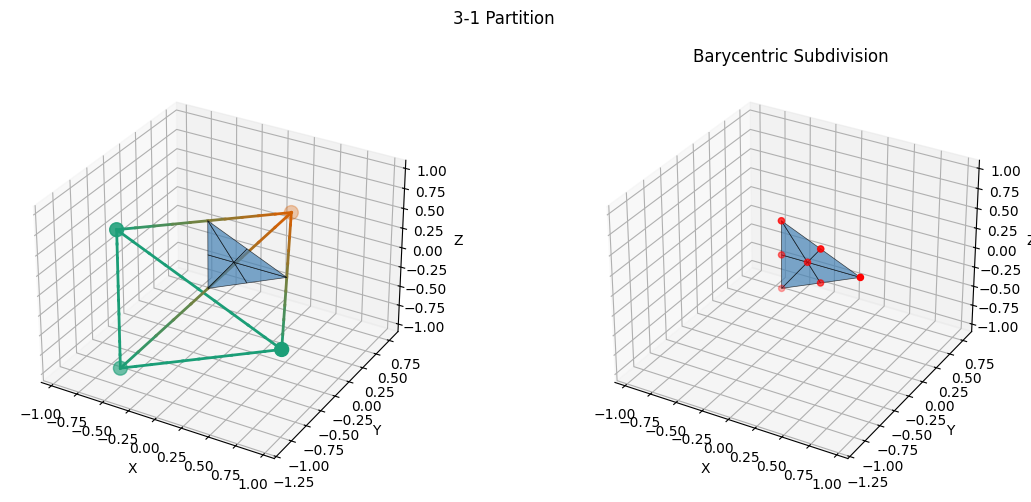

In [8]:
# Visualize 3-1 partition
surface = gen.compute_interface_surface(EXAMPLE_31['points'], EXAMPLE_31['colors'], [], False, False)
fig = plot_tetrahedron_subdivision(EXAMPLE_31['points'], EXAMPLE_31['colors'], surface,
                                    title=EXAMPLE_31['name'])
plt.show()

## 3. Protein Interface Example

Load and visualize a protein dimer interface (4bmg).

In [9]:
# Load protein example
with open('../tests/data/ground_truth_4bmg_dimer_alpha.json', 'r') as f:
    protein_data = json.load(f)

inp = protein_data['input']
points = inp['points']
colors = inp['color_labels']
radii = inp['radii']

print(f"Protein: 4bmg_dimer")
print(f"  Points: {len(points)}")
print(f"  Unique colors: {len(set(colors))}")
print(f"  Radii range: [{min(radii):.2f}, {max(radii):.2f}]")

Protein: 4bmg_dimer
  Points: 2259
  Unique colors: 2
  Radii range: [2.82, 3.28]


In [10]:
# Compute interface surface (weighted alpha complex)
surface = gen.compute_interface_surface(points, colors, radii, True, True)

num_triangles = sum(1 for s, v in surface.filtration if len(s) == 3)
print(f"Interface surface:")
print(f"  Vertices: {len(surface.vertices)}")
print(f"  Triangles: {num_triangles}")

Interface surface:
  Vertices: 3328
  Triangles: 6098


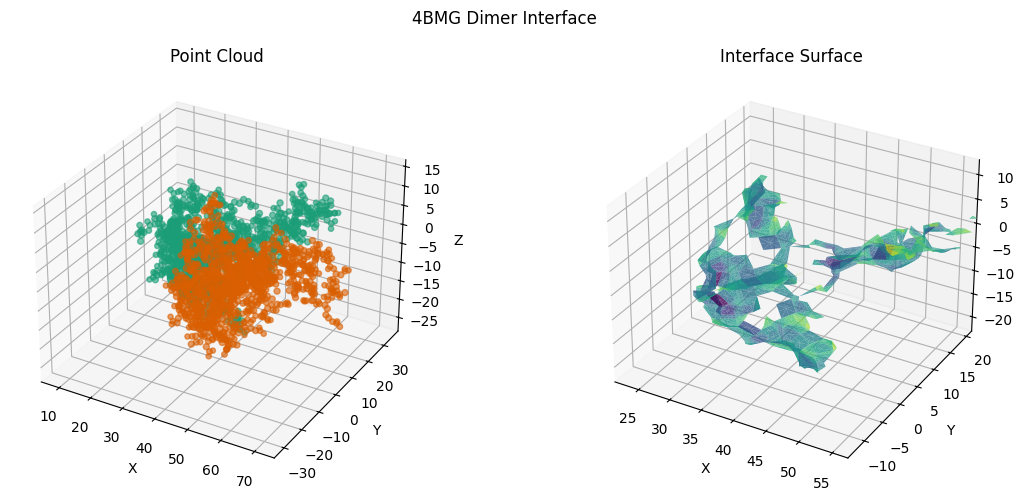

In [11]:
# Visualize protein interface
# Use atom radii only (subtract probe radius used in surface generation)
probe_radius = 1.4
atom_radii = [r - probe_radius for r in radii]

fig = plot_interface_and_pointcloud(surface, points, colors, atom_radii, title="4BMG Dimer Interface")
plt.show()